In [1]:
import numpy as np
import numba
import sklearn.datasets
import umap
import pynndescent
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.sparse
import sklearn.metrics

from collections import namedtuple
from sklearn.preprocessing import normalize

sns.set(rc={"figure.figsize":(12, 12)})

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/high-d-clustering/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lmmcinn/local/sandbox/leland/anaconda3/envs/high-d-clustering/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hom

## Build the Graph

The goal is to contruct a graph with edge weights given by estimating the probability of being the nearest neighbor. How can we estimate such a probability? Surely the sample is either the nearest neighbor or it isn't? We assume sampling has been random and somewhat noisy; but that the distribution of samples is *locally* uniform. In other words we assume that in a local region there is a distribution of distances to the nearest neighbor. This distribution is asymptotically a Gamma distribution; since we are in high dimensions this can be well approximated by a normal distribution (which is much cheaper to model, and to compute probabilities for). Thus for each sample we consider it's local neighborhood and fit a model of the distance to the nearest neighbor for samples in that neighborhood. Given such a model we can then compute the probability that the nearest neighbor of the sample is at least as far away as any given sample, and thus create an edge with w weight given by the probability that this point would have been the nearest neighbor under our model. This provides a (directed!) graph with proabiulities assigned to edges.

In [161]:
@numba.njit(fastmath=True)
def update_model_using_sample_estimate(mu_0, nu, alpha, beta, sample_mean, sample_var, sample_n):
    
    alpha = alpha + sample_n/2
    beta = beta + (sample_n * sample_var) / 2 + (sample_n * nu * (mu_0 - sample_mean)**2 / (2 * (sample_n + nu)))
    mu = (mu_0 * nu + sample_mean * sample_n) / (nu + sample_n)
    sigma = np.sqrt(beta / (alpha + 1))
    
    return mu, sigma

@numba.njit()
def propagate_models(nn_inds, model_mus, model_sigmas, model_nus, model_alphas, model_betas):
    
    result_mus = model_mus.copy()
    result_sigmas = model_sigmas.copy()
    result_nus = model_nus.copy()
    result_alphas = model_alphas.copy()
    result_betas = model_betas.copy()
    
    sample_n = nn_inds.shape[1] - 1
    
    for i in range(nn_inds.shape[0]):
        sample_mean = 0.0
        sample_var = 0.0
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            if k == i:
                continue
                
#             sample_mean += model_mus[k]
#             sample_var += model_mus[k]**2
            
#         sample_mean /= sample_n
#         sample_var = sample_var / sample_n - sample_mean ** 2
#         result_alphas[i] += sample_n / 2.0
#         result_betas[i] += (
#             (sample_n * sample_var) / 2 + 
#             (sample_n * model_nus[i] * (model_mus[i] - sample_mean)**2 / (2 * (sample_n + model_nus[i])))
#         )
#         result_mus[i] = (model_mus[i] * model_nus[i] + sample_mean * sample_n) / (model_nus[i] + sample_n)
#         result_sigmas[i] = result_betas[i] / (result_alphas[i] + 1)
#         result_nus[i] += sample_n

            
#             if model_sigmas[k] > 0:
#                 d = nn_dists[i, j]
#                 erfc_input = (d - model_mus[k]) / (np.sqrt(2 * model_sigmas[k]))
#                 p = math.erfc(erfc_input) / 2.0
#             else:
#                 p = 1.0
                
#             nu = p * model_nus[k]
#             result_alphas[i] += nu / 2.0
#             result_betas[i] += (
#                 nu * model_sigmas[k] / 2.0 + 
#                 nu * result_nus[i] * (result_mus[i] - model_mus[k]) ** 2 /
#                 (2 * (nu + result_nus[i]))
#             )
#             result_mus[i] = (result_mus[i] * result_nus[i] + model_mus[k] * nu) / (result_nus[i] + nu)
#             result_sigmas[i] = result_betas[i] / (result_alphas[i] + 1)
#             result_nus[i] += nu
            
            result_alphas[i] += model_nus[k] / 2.0
            result_betas[i] += (
                model_nus[k] * model_sigmas[k] / 2.0 + 
                model_nus[k] * result_nus[i] * (result_mus[i] - model_mus[k]) ** 2 /
                (2 * (model_nus[k] + result_nus[i]))
            )
            result_mus[i] = (result_mus[i] * result_nus[i] + model_mus[k] * model_nus[k]) / (result_nus[i] + model_nus[k])
            result_sigmas[i] = result_betas[i] / (result_alphas[i] + 1)
            result_nus[i] += model_nus[k]
        
    return result_mus, result_sigmas, result_nus, result_alphas, result_betas

@numba.njit()
def build_models_prop(nn_inds, nn_dists, n_iter=3, prior_strength=0.05):
    
    model_mus = (1.0 - prior_strength) * nn_dists + prior_strength * np.mean(nn_dists)
    model_sigmas = np.zeros_like(nn_dists)
    model_nus = np.ones_like(nn_dists)# + prior_strength
    model_alphas = np.ones_like(nn_dists) / 2.0
    model_betas = np.var(nn_dists) * model_alphas # np.zeros_like(nn_dists)
    
    for i in range(n_iter):
        model_mus, model_sigmas, model_nus, model_alphas, model_betas = propagate_models(
            nn_inds, model_mus, model_sigmas, model_nus, model_alphas, model_betas
        )
    
    return np.vstack((model_mus, np.sqrt(model_sigmas))).T

@numba.njit(fastmath=True)
def build_models_old(nn_inds, nn_dists, prior_strength=0.05):
    prior_mean = np.mean(nn_dists)
    prior_var = np.var(nn_dists)
    
    prior_nu = prior_strength * nn_inds.shape[1] ** 2
    prior_alpha = prior_nu / 2.0
    prior_beta = prior_var * prior_alpha
    
    result = np.zeros((nn_inds.shape[0], 2), dtype=np.float32)
    sums = np.zeros(nn_inds.shape[0], dtype=np.float32)
    sums_of_squares = np.zeros(nn_inds.shape[0], dtype=np.float32)
    counts = np.zeros(nn_inds.shape[0], dtype=np.float32)
    # Get sums and counts for the 1-out (not including the points own 1-nn dist)
    for i in range(nn_inds.shape[0]):
        for j in range(1, nn_inds.shape[1]):
            k = nn_inds[i, j]
            if k != i and nn_dists[k] > 0.0: # Skip zero dists since they don't fit the model
                d = nn_dists[k]
                sums[i] += d
                sums_of_squares[i] += d * d
                counts[i] += 1.0
                
    # Total up totals for the 2-out then compute the mean and std
    for i in range(nn_inds.shape[0]):
        count = 0
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            result[i, 0] += sums[k]
            result[i, 1] += sums_of_squares[k]
            count += counts[k]
            
        result[i, 0] /= count
        result[i, 1] = result[i, 1] / count - result[i, 0] ** 2
        
        # Update to prior
        result[i] = update_model_using_sample_estimate(prior_mean, prior_nu, prior_alpha, prior_beta, result[i, 0], result[i, 1], count)

    return result

# Create an edge list of the (directed!) prob of being a nearest neighbor
# This amounts to just computing the relevant prob of the relevant normal using erfc from
# the math library.
@numba.njit(fastmath=True, parallel=True)
def build_edges(nn_inds, nn_dists, models, max_total_weight=32.0, min_prob=1e-3):
    result_rows = np.zeros(nn_inds.shape[0] * nn_inds.shape[1], dtype=np.int32)
    result_cols = np.zeros(nn_inds.shape[0] * nn_inds.shape[1], dtype=np.int32)
    result_vals = np.zeros(nn_inds.shape[0] * nn_inds.shape[1], dtype=np.float32)
    root_two = np.sqrt(2)
    for i in numba.prange(nn_inds.shape[0]):
        result_idx = i * nn_inds.shape[1]
        mean = models[i, 0]
        std = models[i, 1]
        total_weight = 0.0

        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            if nn_dists[i, j] == 0:
                if i != k:
                    result_rows[result_idx] = i
                    result_cols[result_idx] = k
                    result_vals[result_idx] = 1.0
                    total_weight += 1.0
                    result_idx += 1
                    continue
                else:
                    continue

            d = nn_dists[i, j]
            if std > 0:
                erfc_input = (d - mean) / (root_two * std)
                val = math.erfc(erfc_input) / 2.0
            else:
                val = 0.0

            total_weight += val
            if total_weight > max_total_weight or val < min_prob:
                break
            else:
                result_rows[result_idx] = i
                result_cols[result_idx] = k
                result_vals[result_idx] = val
                result_idx += 1

    return result_rows, result_cols, result_vals

@numba.njit(fastmath=True, parallel=True)
def build_edges_csr(nn_inds, nn_dists, models, max_total_weight=32.0, min_prob=1e-3):
    indptr = np.arange(0, nn_inds.shape[0] * nn_inds.shape[1] + 1, nn_inds.shape[1])
    indices = np.zeros(nn_inds.shape[0] * nn_inds.shape[1], dtype=np.int32)
    data = np.zeros(nn_inds.shape[0] * nn_inds.shape[1], dtype=np.float32)
    
    root_two = np.sqrt(2)
    for i in numba.prange(nn_inds.shape[0]):
        result_idx = i * nn_inds.shape[1]
        mean = models[i, 0]
        std = models[i, 1]
        total_weight = 0.0

        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            if nn_dists[i, j] == 0:
                if i != k:
                    indices[result_idx] = k
                    data[result_idx] = 1.0
                    total_weight += 1.0
                    result_idx += 1
                continue

            d = nn_dists[i, j]
            if std > 0:
                erfc_input = (d - mean) / (root_two * std)
                val = math.erfc(erfc_input) / 2.0
            else:
                val = 0.0

            total_weight += val
            if total_weight > max_total_weight or val < min_prob:
                break
            else:
                indices[result_idx] = k
                data[result_idx] = val
                result_idx += 1

    return indptr, indices, data

def construct_prob_graph(
    data,
    n_neighbors=30,
    metric="euclidean",
    max_total_weight=64.0,
    min_prob=1e-3,
    k=1,
    m=30,
    prior_strength=0.05,
    n_iter=2,
):
    nn_index = pynndescent.NNDescent(data, metric=metric, n_neighbors=n_neighbors, n_trees=8, max_candidates=20)
    nn_inds, nn_dists = nn_index.neighbor_graph
    models = build_models_prop(
        nn_inds[:, :m], nn_dists[:, k], n_iter=n_iter, prior_strength=prior_strength
    )

#     graph_edges = build_edges(
#         nn_inds,
#         nn_dists,
#         models,
#         max_total_weight=max_total_weight,
#         min_prob=min_prob,
#     )
#     result = scipy.sparse.coo_matrix(
#         (
#             graph_edges[2],
#             (graph_edges[0], graph_edges[1]),
#         ),
#         shape=(data.shape[0], data.shape[0]),
#     )
    graph_edges = build_edges_csr(
        nn_inds,
        nn_dists,
        models,
        max_total_weight=max_total_weight,
        min_prob=min_prob,
    )
    result = scipy.sparse.csr_matrix(
        (
            graph_edges[2], graph_edges[1], graph_edges[0]
        ),
        shape=(data.shape[0], data.shape[0]),
    )
    result.eliminate_zeros()

    return result

## Cluster the graph

We can run single linkage clustering on the resulting graph, and then use HDBSCAN style condensed tree approaches to simplify and get some clusters out. Unfortunately we have a directed graph that may not have a single connected component; that means we need to be able to construct minimal spanning forests, convert them to a set of merge trees, and then run HDBSCAN style tree condensing on the forests of merge trees. None of this is hard, but it is finicky, and we want it all to run fast. Before we get started then we need to build some tools -- specifically a disjoint-set/union-find system which will be used repeatedly in what follows.

In [3]:
RankDisjointSet = namedtuple("DisjointSet", ["parent", "rank"])
SizeDisjointSet = namedtuple("DisjointSet", ["parent", "size"])


@numba.njit()
def ds_rank_create(n_elements):
    return RankDisjointSet(np.arange(n_elements, dtype=np.int32), np.zeros(n_elements, dtype=np.int32))


@numba.njit()
def ds_size_create(n_elements):
    return SizeDisjointSet(np.arange(n_elements, dtype=np.int32), np.ones(n_elements, dtype=np.int32))


@numba.njit()
def ds_find(disjoint_set, x):
    while disjoint_set.parent[x] != x:
        x, disjoint_set.parent[x] = disjoint_set.parent[x], disjoint_set.parent[disjoint_set.parent[x]]

    return x


@numba.njit()
def ds_union_by_rank(disjoint_set, x, y):
    x = ds_find(disjoint_set, x)
    y = ds_find(disjoint_set, y)

    if x == y:
        return

    if disjoint_set.rank[x] < disjoint_set.rank[y]:
        x, y = y, x

    disjoint_set.parent[y] = x
    if disjoint_set.rank[x] == disjoint_set.rank[y]:
        disjoint_set.rank[x] += 1


@numba.njit()
def ds_union_by_size(disjoint_set, x, y):
    x = ds_find(disjoint_set, x)
    y = ds_find(disjoint_set, y)

    if x == y:
        return

    if disjoint_set.size[x] < disjoint_set.size[y]:
        x, y = y, x

    disjoint_set.parent[y] = x
    disjoint_set.size[x] += disjoint_set.size[y]

Next we need single linkage clustering of the graph. That is most easily done by computing a minimum spanning forest, and then processing that into a forest of merge trees. We could use scipy here, but we want flexibility (for forests instead of trees), and they just use Kruskal's algorithm anyway, which is easy to reproduce here. After that we just need the standard process for converting a spanning tree (or forest) to a merge tree (or forest). In practice I think this can all be simplified to one function, since we are doing the merge work in Kruskal's but for now let's keep things as separate standard algorithms.

Note that to use minimum spanning forests, and merge order structures we need things going in the other order than probabilities, so we just use negative logs (after all, it's only order that matters).

In [159]:
@numba.njit()
def kruskal_minimum_spanning_forest(rows, cols, data, n_vertices):
    
    result_row = np.zeros(n_vertices - 1, dtype=np.int64)
    result_col = np.zeros(n_vertices - 1, dtype=np.int64)
    result_data = np.zeros(n_vertices - 1, dtype=np.float32)
    mst_edge_idx = 0
        
    edge_order = np.argsort(data)
    disjoint_set = ds_rank_create(n_vertices)
    
    for n in range(data.shape[0]):
        edge_idx = edge_order[n]
        i = rows[edge_idx]
        j = cols[edge_idx]
        
        i_component = ds_find(disjoint_set, i)
        j_component = ds_find(disjoint_set, j)
        
        if i_component != j_component:
            result_row[mst_edge_idx] = i
            result_col[mst_edge_idx] = j
            result_data[mst_edge_idx] = data[edge_idx]
            mst_edge_idx += 1

            if disjoint_set.rank[i_component] < disjoint_set.rank[j_component]:
                i_component, j_component = j_component, i_component

            disjoint_set.parent[j_component] = i_component
            if disjoint_set.rank[i_component] == disjoint_set.rank[j_component]:
                disjoint_set.rank[i_component] += 1
            
            if mst_edge_idx >= n_vertices - 1:
                break
            
    return result_row[:mst_edge_idx], result_col[:mst_edge_idx], result_data[:mst_edge_idx]


@numba.njit(parallel=True)
def boruvka_internal_loop(indptr, indices, data, component_map, best_prob, best_edge):
    
    n_vertices = indptr.shape[0] - 1
    
    for i in numba.prange(n_vertices):
        
        component = component_map[i]
        
        for j in range(indptr[i], indptr[i+1]):
            k = indices[j]
            other_component = component_map[k]
            
            if component != other_component:
                p = data[j]
                if p > best_prob[component]:
                    best_prob[component] = p
                    best_edge[component, 0] = i
                    best_edge[component, 1] = k
                if p > best_prob[other_component]:
                    best_prob[other_component] = p
                    best_edge[other_component, 0] = k
                    best_edge[other_component, 1] = i
                    
    return
    

@numba.njit()
def boruvka_minimum_spanning_forest(indptr, indices, data):
    
    n_vertices = indptr.shape[0] - 1
    
    best_prob = np.zeros(n_vertices, dtype=np.float32)
    best_edge = np.zeros((n_vertices, 2), dtype=np.int32)
    component_map = np.arange(n_vertices, dtype=np.int32)
    
    disjoint_set = ds_rank_create(n_vertices)
    
    result_row = np.zeros(n_vertices - 1, dtype=np.int64)
    result_col = np.zeros(n_vertices - 1, dtype=np.int64)
    result_data = np.zeros(n_vertices - 1, dtype=np.float32)
    mst_edge_idx = 0
    
    iteration = 0
    
    while mst_edge_idx < n_vertices - 1:
        # print(f"{iteration=}, {np.unique(component_map).shape[0]=}, {mst_edge_idx=}")
        boruvka_internal_loop(indptr, indices, data, component_map, best_prob, best_edge)

        found_an_edge = False
        for i in range(n_vertices):
            if best_prob[i] > 0.0:
                found_an_edge = True
                from_component = ds_find(disjoint_set, best_edge[i, 0])
                to_component = ds_find(disjoint_set, best_edge[i, 1])

                if from_component != to_component:
                    result_row[mst_edge_idx] = best_edge[i, 0]
                    result_col[mst_edge_idx] = best_edge[i, 1]
                    result_data[mst_edge_idx] = best_prob[i]
                    mst_edge_idx += 1

                    if disjoint_set.rank[from_component] < disjoint_set.rank[to_component]:
                        from_component, to_component = to_component, from_component

                    disjoint_set.parent[to_component] = from_component
                    if disjoint_set.rank[from_component] == disjoint_set.rank[to_component]:
                        disjoint_set.rank[from_component] += 1
                        
        for i in range(component_map.shape[0]):
            component_map[i] = ds_find(disjoint_set, i)
            
        best_prob[:] = 0.0
        best_edge[:] = 0
        
        iteration += 1
        
        if not found_an_edge:
            break
            
    return result_row[:mst_edge_idx], result_col[:mst_edge_idx], result_data[:mst_edge_idx]    
    

LinkageMergeData = namedtuple("LinkageMergeData", ["parent", "size", "next"])

@numba.njit()
def create_linkage_merge_data(base_size):
    parent = np.full(2 * base_size - 1, -1, dtype=np.intp)
    size = np.concatenate((np.ones(base_size, dtype=np.intp), np.zeros(base_size - 1, dtype=np.intp)))
    next_parent = np.array([base_size], dtype=np.intp)

    return LinkageMergeData(parent, size, next_parent)


@numba.njit()
def linkage_merge_find(linkage_merge, node):
    relabel = node
    while linkage_merge.parent[node] != -1 and linkage_merge.parent[node] != node:
        node = linkage_merge.parent[node]

    linkage_merge.parent[node] = node

    # label up to the root
    while linkage_merge.parent[relabel] != node:
        next_relabel = linkage_merge.parent[relabel]
        linkage_merge.parent[relabel] = node
        relabel = next_relabel

    return node


@numba.njit()
def linkage_merge_join(linkage_merge, left, right):
    linkage_merge.size[linkage_merge.next[0]] = linkage_merge.size[left] + linkage_merge.size[right]
    linkage_merge.parent[left] = linkage_merge.next[0]
    linkage_merge.parent[right] = linkage_merge.next[0]
    linkage_merge.next[0] += 1


@numba.njit()
def msf_to_linkage_forest(sorted_mst, n_samples=-1):
    result = np.empty((sorted_mst.shape[0], sorted_mst.shape[1] + 1))

    if n_samples < 0:
        n_samples = sorted_mst.shape[0] + 1
        
    linkage_merge = create_linkage_merge_data(n_samples)

    for index in range(sorted_mst.shape[0]):

        left = np.intp(sorted_mst[index, 0])
        right = np.intp(sorted_mst[index, 1])
        delta = sorted_mst[index, 2]

        left_component = linkage_merge_find(linkage_merge, left)
        right_component = linkage_merge_find(linkage_merge, right)

        if left_component > right_component:
            result[index][0] = left_component
            result[index][1] = right_component
        else:
            result[index][1] = left_component
            result[index][0] = right_component

        result[index][2] = delta
        result[index][3] = linkage_merge.size[left_component] + linkage_merge.size[right_component]

        linkage_merge_join(linkage_merge, left_component, right_component)

    return result

def merge_forest_from_graph(prob_graph):
    
    if scipy.sparse.isspmatrix_coo(prob_graph):
        graph_for_linkage = prob_graph
    else:
        graph_for_linkage = prob_graph.tocoo()
        
    msf = kruskal_minimum_spanning_forest(
        graph_for_linkage.row, graph_for_linkage.col, -np.log(graph_for_linkage.data), graph_for_linkage.shape[0]
    )
    msf = np.vstack(msf).T
    merge_forest = msf_to_linkage_forest(msf, graph_for_linkage.shape[0])
    
    return merge_forest

def merge_forest_from_graph_boruvka(prob_graph):
        
    if scipy.sparse.isspmatrix_csr(prob_graph):
        csr_graph = prob_graph
    else:    
        csr_graph = prob_graph.tocsr()
        
    msf = boruvka_minimum_spanning_forest(
        csr_graph.indptr, csr_graph.indices, csr_graph.data
    )
    sort_order = np.argsort(msf[2])[::-1]
    msf = np.vstack((msf[0][sort_order], msf[1][sort_order], -np.log(msf[2][sort_order]))).T
    merge_forest = msf_to_linkage_forest(msf, prob_graph.shape[0])
    
    return merge_forest

Next we need to be able to condense trees, and also forests. We can just use the standard ``condense_tree`` code (see fast_hdbscan) with some minor modifications where the number of points isn't automatically/implicitly encoded in the merge tree structure. We then supplement that with the ability to extract out roots of the merge forest, and then simply run ``condense_tree`` for each tree in our merge forest, and glue the whole thing together when done.

In [5]:
@numba.njit()
def bfs_from_hierarchy(hierarchy, bfs_root, num_points):
    to_process = [bfs_root]
    result = []

    while to_process:
        result.extend(to_process)
        next_to_process = []
        for n in to_process:
            if n >= num_points:
                i = n - num_points
                next_to_process.append(int(hierarchy[i, 0]))
                next_to_process.append(int(hierarchy[i, 1]))
        to_process = next_to_process

    return result

@numba.njit()
def eliminate_branch(branch_node, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore, hierarchy,
                     num_points):
    if branch_node < num_points:
        parents[idx] = parent_node
        children[idx] = branch_node
        lambdas[idx] = lambda_value
        idx += 1
    else:
        for sub_node in bfs_from_hierarchy(hierarchy, branch_node, num_points):
            if sub_node < num_points:
                children[idx] = sub_node
                parents[idx] = parent_node
                lambdas[idx] = lambda_value
                idx += 1
            else:
                ignore[sub_node] = True

    return idx


CondensedTree = namedtuple('CondensedTree', ['parent', 'child', 'lambda_val', 'child_size'])

@numba.njit()
def neg_exp(x):
    return np.exp(-x)

@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, root=-1, num_points=-1, next_label=-1, lambda_func=neg_exp):
    
    if root < 0:
        root = 2 * hierarchy.shape[0]
        
    if num_points < 0:
        num_points = hierarchy.shape[0] + 1
        
    if next_label < 0:
        next_label = num_points

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = next_label
    
    next_label += 1

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool8)

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        lambda_value = lambda_func(d)

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else 1
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else 1

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: 
        #   relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

@numba.njit()
def merge_tree_roots(merge_tree, min_cluster_size, n_samples=-1):
    if n_samples < 0:
        n_samples = merge_tree.shape[0] + 1
        
    is_root = np.ones(merge_tree.shape[0], dtype=np.bool_)
    for i in range(merge_tree.shape[0]):
        if merge_tree[i, 0] >= n_samples:
            is_root[int(merge_tree[i, 0] - n_samples)] = False
        if merge_tree[i, 1] >= n_samples:
            is_root[int(merge_tree[i, 1] - n_samples)] = False
        
    roots = np.nonzero(is_root)[0] + n_samples
    
    result = []
    for i in range(roots.shape[0]):
        if merge_tree[roots[i] - n_samples, 3] > min_cluster_size:
            result.append(roots[i])
        
    return result

#@numba.njit()
def condense_forest(merge_forest, min_cluster_size=10, n_samples=-1, lambda_func=neg_exp):

    if n_samples < 0:
        n_samples = merge_tree.shape[0] + 1
        
    roots = merge_tree_roots(merge_forest, min_cluster_size=min_cluster_size, n_samples=n_samples)
    
    ctrees = []
    next_label = n_samples + 1
    for root in roots:
        ctree = condense_tree(
            merge_forest, 
            min_cluster_size=min_cluster_size, 
            root=root, 
            num_points=n_samples,
            next_label=next_label,
            lambda_func=lambda_func,
        )
        next_label = ctree.parent.max() + 1
        ctrees.append(ctree)
        
    result = CondensedTree(
        np.concatenate([x.parent for x in ctrees]),
        np.concatenate([x.child for x in ctrees]),
        np.concatenate([x.lambda_val for x in ctrees]),
        np.concatenate([x.child_size for x in ctrees]),
    )
    return result

Lastly we need to be able to extract clusters. We could use any technique, but I went with the leaf extraction because it seemed to work better. In principle this means we don't need to condense the whole tree, just the leaves which could save a lot of time/trouble, but other extraction methods are possible so I'll stick with flexibility (and borrowed standard algorithms) for now.

In [136]:
@numba.njit
def extract_leaves(condensed_tree, allow_single_cluster=True):
    n_points = condensed_tree.parent.min()
    n_nodes = max(condensed_tree.parent.max() + 1, n_points + 1)
    leaf_indicator = np.ones(n_nodes, dtype=np.bool_)
    leaf_indicator[:n_points] = False

    for parent, child_size in zip(condensed_tree.parent, condensed_tree.child_size):
        if child_size > 1:
            leaf_indicator[parent] = False

    return np.nonzero(leaf_indicator)[0]

@numba.njit()
def get_cluster_label_vector(
        tree,
        clusters,
):
    root_cluster = tree.parent.min()
    result = np.empty(root_cluster, dtype=np.intp)
    cluster_label_map = {c: n for n, c in enumerate(np.sort(clusters))}

    disjoint_set = ds_rank_create(tree.parent.max() + 1)
    clusters = set(clusters)

    for n in range(tree.parent.shape[0]):
        child = tree.child[n]
        parent = tree.parent[n]
        if child not in clusters:
            ds_union_by_rank(disjoint_set, parent, child)

    for n in range(root_cluster):
        cluster = ds_find(disjoint_set, n)
        if cluster in cluster_label_map:
            result[n] = cluster_label_map[cluster]
        else:
            result[n] = -1

    return result


def labels_from_prob_graph(prob_graph, min_cluster_size):
    
    merge_forest = merge_forest_from_graph_boruvka(prob_graph)
#     merge_forest = merge_forest_from_graph(prob_graph)
    condensed_forest = condense_forest(merge_forest, min_cluster_size=min_cluster_size, n_samples=prob_graph.shape[0])
    chosen_clusters = extract_leaves(condensed_forest)
    
    result = get_cluster_label_vector(condensed_forest, chosen_clusters)
    
    return result

## Propagate labels through the graph

The clustering of the graph works well in that it picks out most of the clusters, but it leaves a great deal of data as noise. We can fix that by running a label propagation through the graph. We do still want to keep the ability to label points as noise, and it would be good to keep the propagation soft, so we can do a Bayesian label propagation of probability vectors over possible labels, including a noise label, with a Bayesian update of the distribution at each propagation round. We can then iterate until relative convergence.

In [7]:
# A basic Bayesian label prop with a few quirks
# Quirks: Different vertices have different (weighted) degrees; we normalize so the total outgoing weight is consistent
#         We reassert labels each iteration boosting the prior; this includes a level of noise prior which is a parameter
#         This is not really theoretically sound, but it prevents labels over-running where they shouldn't. We could in
#         theory simply hold labelled vertics fixed; I haven't experimented with that much yet.
@numba.njit(fastmath=True, parallel=True)
def bayesian_label_prop_iteration(
    indptr, indices, probs, vertex_label_probs, labels, degree_correction, row_weights, label_prior=0.9, noise_prior=0.2
):
    
    n_rows = indptr.shape[0] - 1
    n_labels = vertex_label_probs.shape[1]
    vertex_votes = np.zeros_like(vertex_label_probs, dtype=np.float64)
    norms = np.zeros(n_rows)
    
    if label_prior < 1.0:
        label_multiplier = label_prior / (1.0 - label_prior)
    else:
        label_multiplier = 1e16
    if noise_prior < 1.0:
        noise_multiplier = noise_prior / (1.0 - noise_prior)
    else:
        noise_multiplier = 1e16
    
    for i in numba.prange(n_rows):
        if labels[i] >= 0:
            vertex_votes[i] = label_multiplier * row_weights[i] * vertex_label_probs[i]
            norms[i] += label_multiplier * row_weights[i]
        else:
            vertex_votes[i] = noise_multiplier * row_weights[i] * vertex_label_probs[i]
            norms[i] += noise_multiplier * row_weights[i]
        
    for i in numba.prange(n_rows):
        for k in range(indptr[i], indptr[i+1]):
            j = indices[k]
            prob = probs[k] * degree_correction[i]
            
            for l in range(n_labels):
                vertex_votes[i, l] += prob * vertex_label_probs[j, l]
                
            norms[i] += prob
        
    for i in numba.prange(n_rows):
        if norms[i] > 0.0:
            vertex_votes[i] /= norms[i]
        else:
            vertex_votes[i, -1] = 1.0
            
    return vertex_votes


@numba.njit(fastmath=True, parallel=True)
def bayesian_label_prop_loop(
    indptr, indices, data, degree_correction, row_weights,
    label_vector, max_iter=100, tolerance=1e-5, label_prior=0.9, noise_prior=0.2
):
    n_vertices = indptr.shape[0] - 1
    vertex_label_probs = np.zeros((n_vertices, label_vector.max() + 2), dtype=np.float64)
    for i in range(vertex_label_probs.shape[0]):
        vertex_label_probs[i, label_vector[i]] = 1.0
        
    for i in range(max_iter):
        next_vertex_label_probs = bayesian_label_prop_iteration(
            indptr, 
            indices, 
            data, 
            vertex_label_probs, 
            label_vector,
            degree_correction,
            row_weights,
            noise_prior=noise_prior,
            label_prior=label_prior,
        )
        
        total_change = np.sqrt(np.sum((vertex_label_probs - next_vertex_label_probs)**2))
        
        if total_change / n_vertices < tolerance:
            return next_vertex_label_probs
        else:
            vertex_label_probs = next_vertex_label_probs    
    
    return vertex_label_probs

@numba.njit(parallel=True, fastmath=True)
def degree_correction_and_row_weights(indptr, indices, data):
    
    n_rows = indptr.shape[0] - 1
    degrees = np.full(n_rows, 1e-16, dtype=np.float32)
    
    for n in range(indices.shape[0]):
        j = indices[n]
        degrees[j] += data[n]
        
    degree_correction = 1.0 / degrees
    row_weights = np.zeros(n_rows, dtype=np.float32)
    
    for i in numba.prange(n_rows):
        for n in range(indptr[i], indptr[i+1]):
            j = indices[n]
            row_weights[i] += data[n] * degree_correction[j]
            
    return degree_correction, row_weights

def bayesian_label_prop(prob_graph, label_vector, max_iter=100, tolerance=1e-5, label_prior=0.9, noise_prior=0.2):
    if not scipy.sparse.isspmatrix_csr(prob_graph):
        prob_graph = prob_graph.tocsr()
        
    degree_correction, row_weights = degree_correction_and_row_weights(
        prob_graph.indptr, 
        prob_graph.indices, 
        prob_graph.data,
    )
    
    vertex_label_probs = bayesian_label_prop_loop(
        prob_graph.indptr, 
        prob_graph.indices, 
        prob_graph.data,
        degree_correction,
        row_weights,
        label_vector,
        max_iter=max_iter,
        tolerance=tolerance,
        label_prior=label_prior,
        noise_prior=noise_prior,
    )
            
    return vertex_label_probs

## Putting it all together

We can now put together a clustering algorithm from these pieces. This follows exactly the sections: create the graph; cluster the graph; propagate the initial cluster labels through the graph.

In [8]:
def clusters(
    data,
    metric="euclidean",
    n_neighbors=30,
    min_cluster_size=10,
    max_total_weight=64.0, 
    min_prob=1e-3,
    label_prior=0.9,
    noise_prior=0.2, 
    max_iter=100, 
    tolerance=1e-5,
    k=1,
    model_prior_strength=0.2,
    n_iter=2,
):
    prob_graph = construct_prob_graph(
        data, 
        n_neighbors=n_neighbors, 
        metric=metric, 
        max_total_weight=max_total_weight, 
        min_prob=min_prob,
        k=k,
        prior_strength=model_prior_strength,
        n_iter=n_iter,
    )
    label_vector = labels_from_prob_graph(prob_graph, min_cluster_size)
    cluster_prob_vector = bayesian_label_prop(
        prob_graph, label_vector, 
        noise_prior=noise_prior,
        label_prior=label_prior,
        max_iter=max_iter, 
        tolerance=tolerance,
    )
    result = np.argmax(cluster_prob_vector, axis=1)
    result[result == label_vector.max() + 1] = -1
    
    return result

## Experiments

We'll run this algorithm (with tuned parameters) and compare it with a combination of UMAP and HDBSCAN (with tuned parameters). This algorithm was developed largely against MNIST, so it is perhaps somewhat overtuned to MNIST. You may want to substitute in your own favourite dataset instead; alhtough it should be "high dimensional" enough the not require Gamma distribution models (above about 10 should probably be enough).

In [9]:
mnist = sklearn.datasets.fetch_openml("mnist_784")

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/high-d-clustering/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
%%time
mnist_umap = umap.UMAP(min_dist=0.25).fit_transform(mnist.data)

CPU times: user 4min 48s, sys: 4.59 s, total: 4min 52s
Wall time: 1min 18s


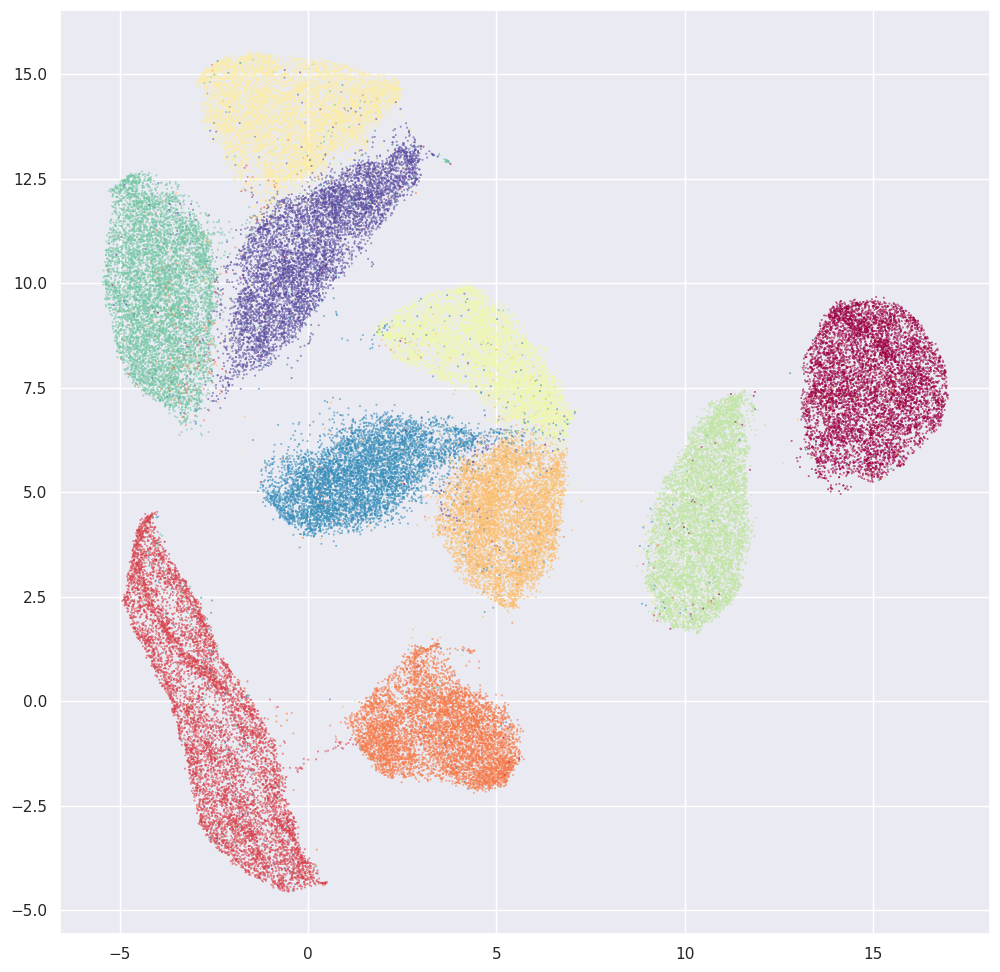

In [11]:
plt.scatter(*mnist_umap.T, s=0.1, c=mnist.target.astype(np.int8), cmap="Spectral")

The first run does the compilation; the second run gives a better sense of time required.

In [12]:
%%time
mnist_clusters = clusters(mnist.data, min_cluster_size=800, n_neighbors=30)

CPU times: user 1min 20s, sys: 4.29 s, total: 1min 24s
Wall time: 33.5 s


In [13]:
mnist_data = np.ascontiguousarray(mnist.data, dtype=np.float32)

In [172]:
%load_ext line_profiler

In [176]:
%lprun -f construct_prob_graph clusters(mnist_data, min_cluster_size=800, n_neighbors=15,max_iter=50, label_prior=0.99, noise_prior=0.01, model_prior_strength=0.0,n_iter=3,)

In [207]:
%%prun -s cumulative
mnist_clusters = clusters(
    mnist_data, 
    min_cluster_size=800, 
    n_neighbors=15,
    max_iter=50, 
    label_prior=0.99, 
    noise_prior=0.01, 
    k=1,
    min_prob=1e-4,
    model_prior_strength=0.0,
    n_iter=3,
)

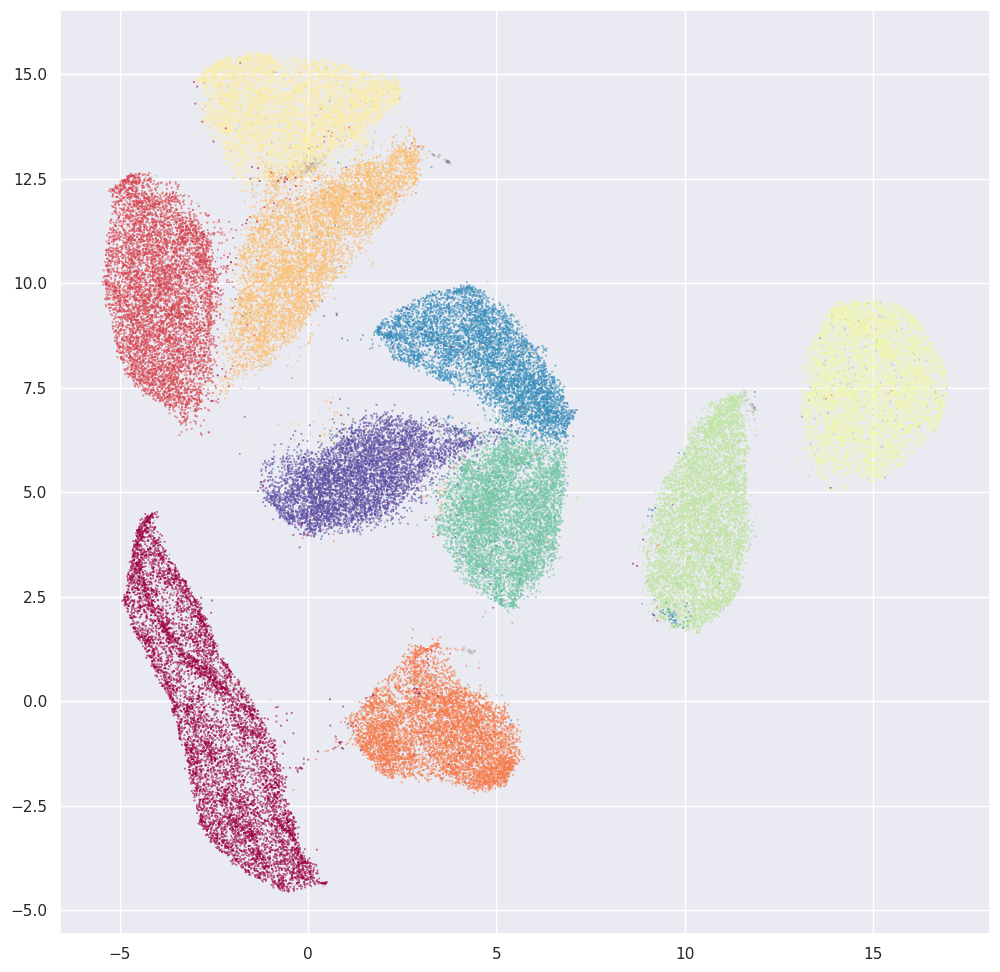

In [208]:
plt.scatter(*mnist_umap[mnist_clusters < 0].T, s=0.1, c="gray", alpha=0.5)
plt.scatter(*mnist_umap[mnist_clusters >= 0].T, s=0.1, c=mnist_clusters[mnist_clusters >=0], cmap="Spectral")

In [209]:
sklearn.metrics.adjusted_rand_score(mnist.target[mnist_clusters >= 0], mnist_clusters[mnist_clusters >= 0])

0.9229811173982858

In [210]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target[mnist_clusters >= 0], mnist_clusters[mnist_clusters >= 0])

0.9131907011008483

In [211]:
np.sum(mnist_clusters >= 0) / mnist_clusters.shape[0]

0.9804285714285714

As before; we run twice to ensure timings don't include JIT compile time.

In [19]:
%%time
uhdb_clusters = hdbscan.HDBSCAN(
    min_samples=5, min_cluster_size=300
).fit_predict(umap.UMAP(min_dist=1e-4).fit_transform(mnist.data))

CPU times: user 4min 13s, sys: 4.25 s, total: 4min 17s
Wall time: 42.6 s


In [20]:
%%time
uhdb_clusters = hdbscan.HDBSCAN(
    min_samples=5, min_cluster_size=300
).fit_predict(umap.UMAP(min_dist=1e-4).fit_transform(mnist.data))

CPU times: user 4min 12s, sys: 4.44 s, total: 4min 16s
Wall time: 41.4 s


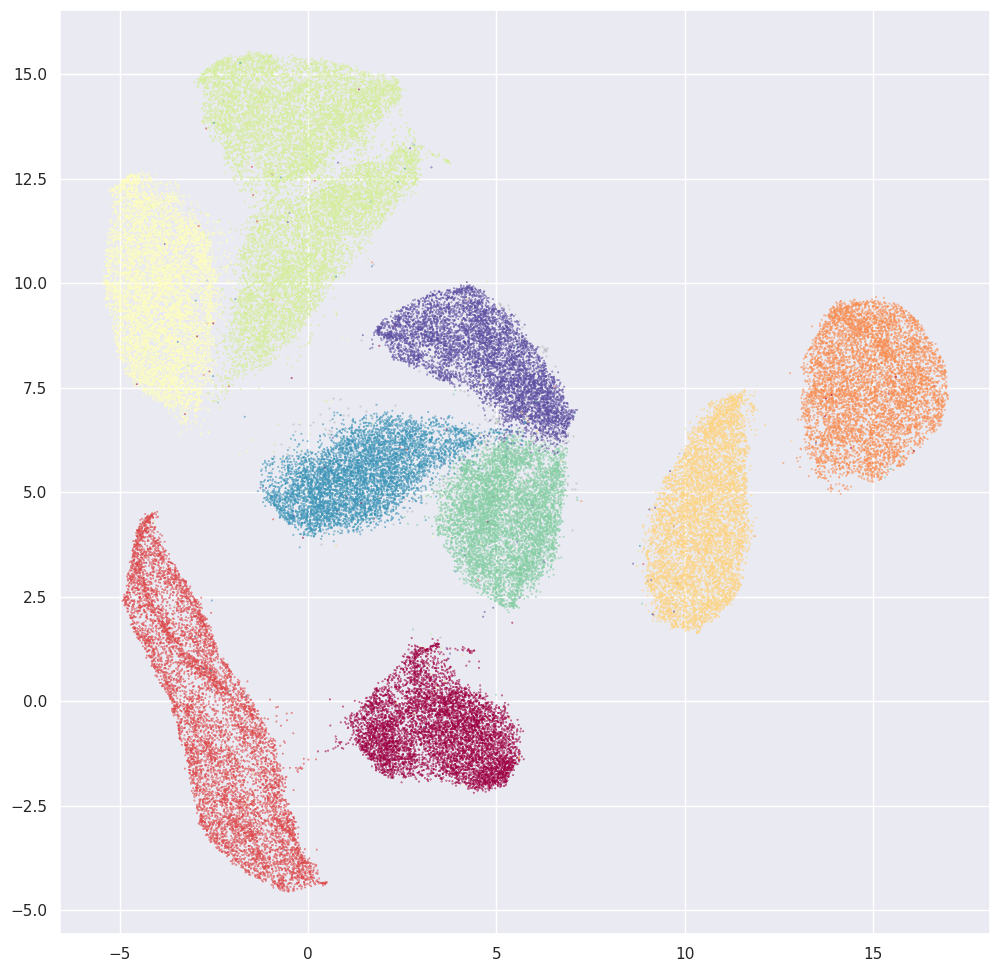

In [21]:
plt.scatter(*mnist_umap[uhdb_clusters < 0].T, s=0.1, c="gray", alpha=0.5)
plt.scatter(*mnist_umap[uhdb_clusters >= 0].T, s=0.1, c=uhdb_clusters[uhdb_clusters >=0], cmap="Spectral")

In [22]:
sklearn.metrics.adjusted_rand_score(mnist.target[uhdb_clusters >= 0], uhdb_clusters[uhdb_clusters >= 0])

0.844831574463598

In [23]:
sklearn.metrics.adjusted_mutual_info_score(mnist.target[uhdb_clusters >= 0], uhdb_clusters[uhdb_clusters >= 0])

0.8940031886431428

In [24]:
np.sum(uhdb_clusters >= 0) / uhdb_clusters.shape[0]

0.9965571428571428

In [25]:
nn_index = pynndescent.NNDescent(mnist.data, n_neighbors=150)
nn_inds, nn_dists = nn_index.neighbor_graph

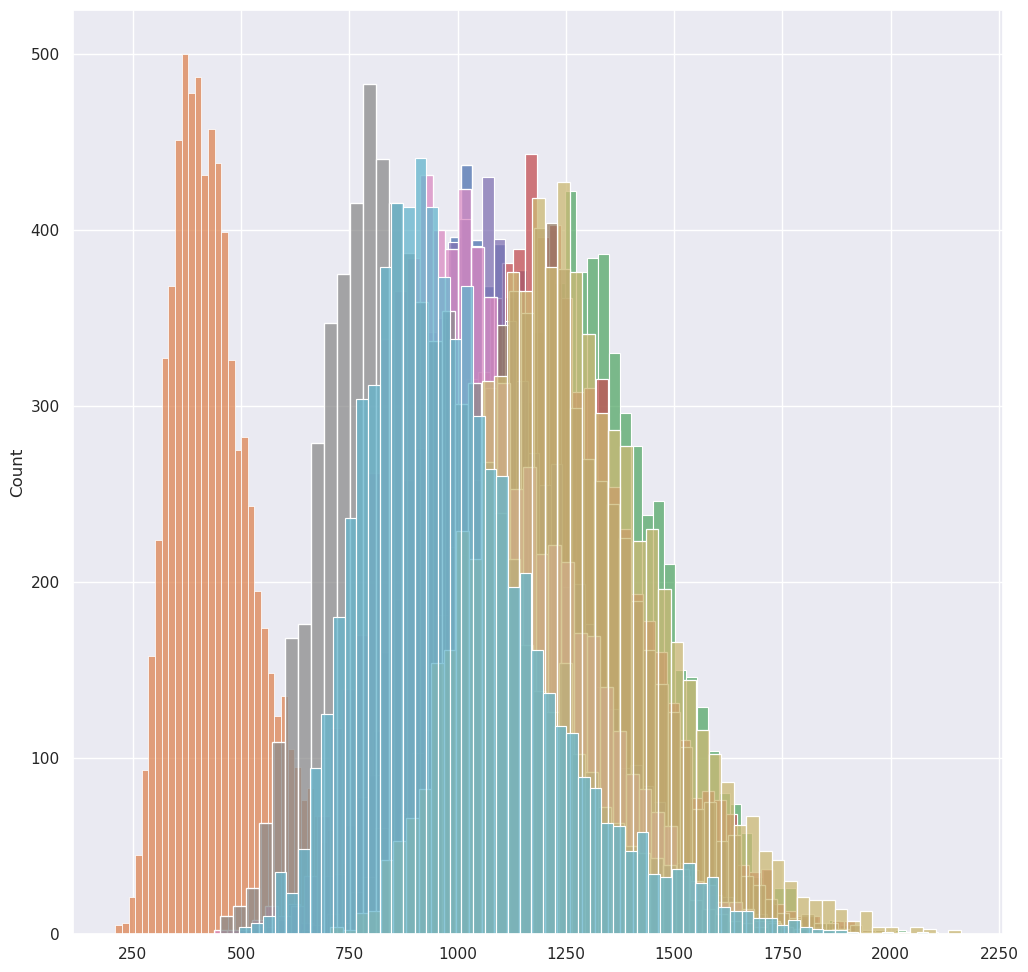

In [26]:
for i in range(10):
    sns.histplot(np.abs(nn_dists.T[1][mnist.target == str(i)]))

In [27]:
%%time
build_models(nn_inds, nn_dists.T[1])

NameError: name 'build_models' is not defined

In [28]:
%%time
build_models_prop(nn_inds, nn_dists.T[1], n_iter=3)

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.19 s


array([[1062.99142234,  150.19046021],
       [ 964.86217106,  112.50875092],
       [1031.06546304,  150.57452393],
       ...,
       [ 891.6039241 ,  127.27362061],
       [ 971.72772124,  133.75366211],
       [ 957.14817024,  129.79057312]])

In [29]:
np.mean(nn_dists.T[1]), np.std(nn_dists.T[1])

(1055.3833, 308.3518)

In [30]:
np.sum(nn_dists.T[1] == 0)

0

In [31]:
mus = nn_dists.T[1].copy()
for i in range(1):
    mus = mus[nn_inds].mean(axis=1)
np.sum(mus < nn_dists.T[1])

50043

In [32]:
import inspect

In [33]:
print(inspect.getsource(bayesian_label_prop))

def bayesian_label_prop(prob_graph, label_vector, max_iter=100, tolerance=1e-5, label_prior=0.9, noise_prior=0.2):
    if not scipy.sparse.isspmatrix_csr(prob_graph):
        prob_graph = prob_graph.tocsr()
        
    degree_correction, row_weights = degree_correction_and_row_weights(
        prob_graph.indptr, 
        prob_graph.indices, 
        prob_graph.data,
    )
    
    vertex_label_probs = bayesian_label_prop_loop(
        prob_graph.indptr, 
        prob_graph.indices, 
        prob_graph.data,
        degree_correction,
        row_weights,
        label_vector,
        max_iter=max_iter,
        tolerance=tolerance,
        label_prior=label_prior,
        noise_prior=noise_prior,
    )
            
    return vertex_label_probs



In [40]:
prob_graph = construct_prob_graph(mnist_data, n_neighbors=15, n_iter=3)

In [41]:
prob_graph

<70000x70000 sparse matrix of type '<class 'numpy.float32'>'
	with 801912 stored elements in COOrdinate format>

In [135]:
%%prun
merge_forest_from_graph_boruvka(prob_graph)

In [133]:
merge_forest_from_graph_boruvka(prob_graph)

array([[7.81000000e+02, 7.43000000e+02, 4.08660807e-03, 2.00000000e+00],
       [6.02750000e+04, 3.86680000e+04, 4.29244898e-03, 2.00000000e+00],
       [6.60740000e+04, 5.65580000e+04, 4.53545433e-03, 2.00000000e+00],
       ...,
       [1.38106000e+05, 5.05170000e+04, 6.90602970e+00, 6.80680000e+04],
       [1.38107000e+05, 6.24050000e+04, 6.90686607e+00, 6.80690000e+04],
       [1.38108000e+05, 4.72470000e+04, 6.90734720e+00, 6.80700000e+04]])

In [134]:
merge_forest_from_graph(prob_graph)

array([[7.81000000e+02, 7.43000000e+02, 4.08660807e-03, 2.00000000e+00],
       [6.02750000e+04, 3.86680000e+04, 4.29244898e-03, 2.00000000e+00],
       [6.60740000e+04, 5.65580000e+04, 4.53545433e-03, 2.00000000e+00],
       ...,
       [1.38106000e+05, 5.05170000e+04, 6.90602970e+00, 6.80680000e+04],
       [1.38107000e+05, 6.24050000e+04, 6.90686607e+00, 6.80690000e+04],
       [1.38108000e+05, 4.72470000e+04, 6.90734720e+00, 6.80700000e+04]])

In [216]:
np.arange(0, 30 + 1, 3).shape

(11,)